#### Goal:
x and y position of beam spot

#### Data:
- background image
- beam image
- viewer grid size

#### To do:
- warping didn't seem to make a difference. Ideas:
  - get an image of the viewer head on to extract warp matrix from instead of guessing
- use feature detection on a cropped image of the viewer and detect the region
- then use line detection to get the scale?
  - hough transform code not working -> investigate


In [2]:
# import the necessary packages
from __future__ import print_function
from imutils import perspective
from imutils import contours
import numpy as np
import math 
import argparse
import imutils
import cv2
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
def order_points_old(pts):
    # initialize a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect



In [3]:
# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-n", "--new", type=int, default=-1,help="whether or not the new order points should should be used")
#args = vars(ap.parse_args())

# load our input image, convert it to grayscale, and blur it slightly
image = cv2.imread("JENSAviewer_cropped.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#gray = cv2.GaussianBlur(gray, (7, 7), 0)
rows, cols, ch= image.shape 


In [55]:
def GetContour(original, im_input):
    # perform edge detection, then perform a dilation + erosion to
    # close gaps in between object edges
    edged = cv2.Canny(im_input, 50, 100)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    #cv2.imshow("Edged", edged)
    plt.imshow(edged)
    
    # find contours in the edge map
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    # sort the contours from left-to-right and initialize the bounding box
    # point colors
    (cnts, _) = contours.sort_contours(cnts)
    colors = ((0, 0, 255), (240, 0, 159), (255, 0, 0), (255, 255, 0))
       
    # loop over the contours individually
    for (i, c) in enumerate(cnts):
        # if the contour is not sufficiently large, ignore it
        if cv2.contourArea(c) < 100:
            continue
       
        # compute the rotated bounding box of the contour, then
        # draw the contours
        box = cv2.minAreaRect(c)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        cv2.drawContours(im_input, [box], -1, (0, 255, 0), 2)
       
        # show the original coordinates
        print("Object #{}:".format(i + 1))
        print(box)
       
        # order the points in the contour such that they appear
        # in top-left, top-right, bottom-right, and bottom-left
        # order, then draw the outline of the rotated bounding
        # box
        rect = order_points_old(box)
       
        # check to see if the new method should be used for
        # ordering the coordinates
        #if args["new"] > 0:
        #rect = perspective.order_points(box)
    
        # show the re-ordered coordinates
        #print(rect.astype("int"))
    
        # loop over the original points and draw them
        for ((x, y), color) in zip(rect, colors):
            cv2.circle(im_input, (int(x), int(y)), 5, color, -1)
            
        # draw the object num at the top-left corner
        cv2.putText(im_input, "Object #{}".format(i + 1),
            (int(rect[0][0] - 15), int(rect[0][1] - 15)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.55, (255, 255, 255), 2)
        
        # show the image
        fig=plt.figure(figsize=(17,15)) 
        plt.subplot(121),plt.imshow(original),plt.title('Input')
        plt.subplot(122),plt.imshow(im_input),plt.title('Output')
        plt.show()          
    

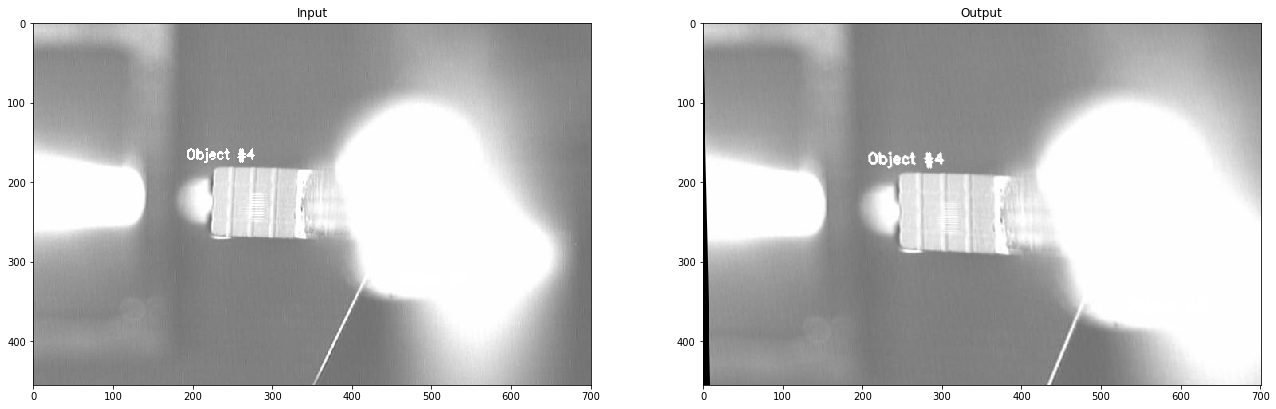

In [56]:
yaw = 0.02 #rotation along z
pitch = -0.00015 #rotation along y
roll = 0.00015 #rotation along x

yaw_matrix = np.matrix([
[math.cos(yaw), -math.sin(yaw), 0],
[math.sin(yaw), math.cos(yaw), 0],
[0, 0, 1]
])

pitch_matrix = np.matrix([
[math.cos(pitch), 0, math.sin(pitch)],
[0, 1, 0],
[-math.sin(pitch), 0, math.cos(pitch)]
])

roll_matrix = np.matrix([
[1, 0, 0],
[0, math.cos(roll), -math.sin(roll)],
[0, math.sin(roll), math.cos(roll)]
])

warp_matrix = yaw_matrix @ pitch_matrix @ roll_matrix 

image_corrected = cv2.warpPerspective(image, warp_matrix, (cols,rows), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

fig=plt.figure(figsize=(22,20))
plt.subplot(121),plt.imshow(image),plt.title('Input')
plt.subplot(122),plt.imshow(image_corrected),plt.title('Output')
plt.show()

Object #4:
[[422 292]
 [205 287]
 [207 186]
 [424 191]]


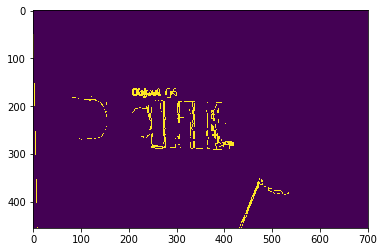

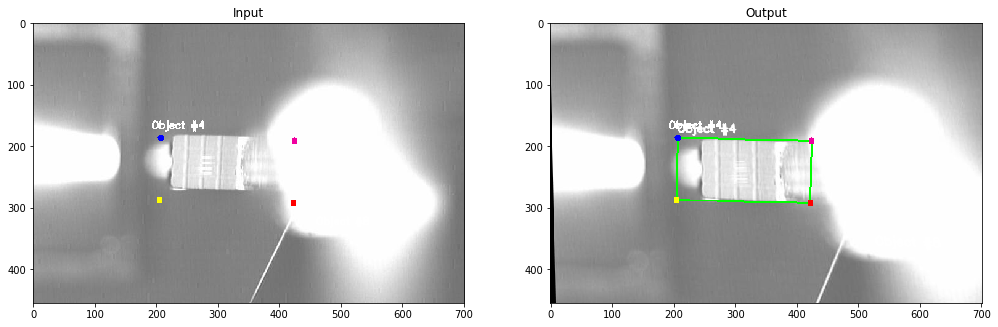

Object #5:
[[207 183]
 [207 162]
 [266 162]
 [266 183]]


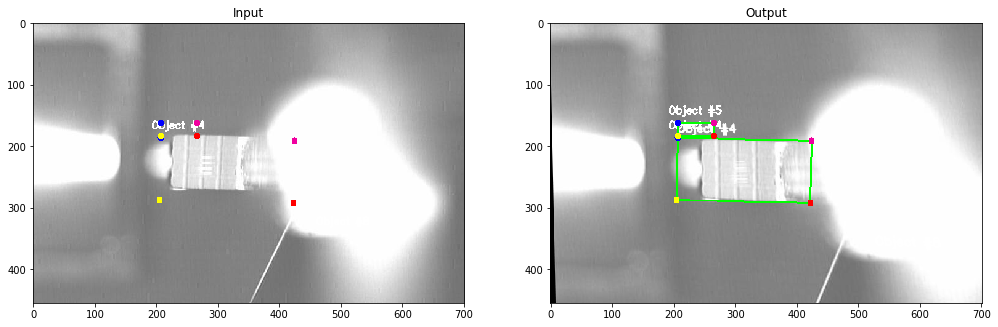

Object #6:
[[277 183]
 [277 163]
 [301 163]
 [301 183]]


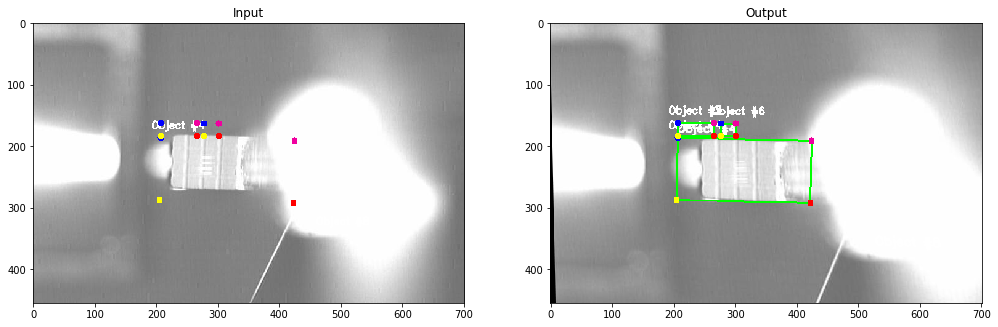

Object #10:
[[492 477]
 [431 453]
 [474 342]
 [535 365]]


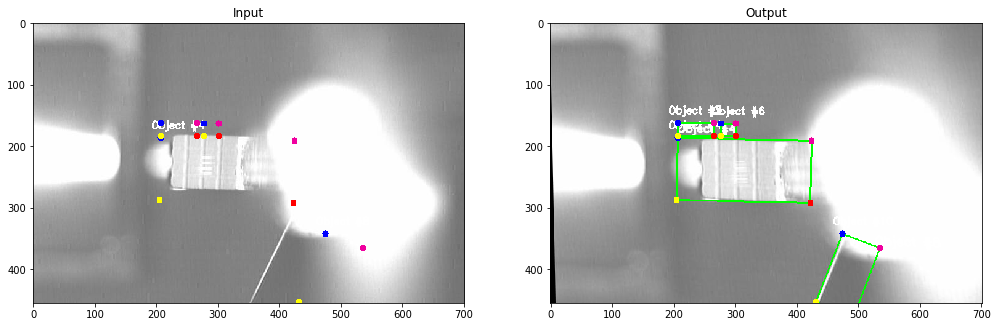

In [57]:
GetContour(image, image_corrected)

TypeError: unhashable type: 'numpy.ndarray'

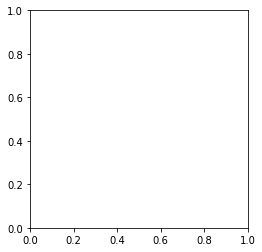

In [3]:
img = cv2.imread("JENSAviewer_cropped.png")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)

lines = cv2.HoughLines(edges,2,np.pi/180, 100)

for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

plt.imshow("Result Image", img)
